In [6]:
import itertools
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class ChiSquarePrunedTree:
    def __init__(self, max_depth=None, min_samples_split=2, alpha=0.05):
        self.tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
        self.alpha = alpha

    def fit(self, X, y):
        self.tree.fit(X, y)
        self.X = X.values if isinstance(X, pd.DataFrame) else X
        self.y = y

    def prune(self):
        tree = self.tree.tree_
        n_nodes = tree.node_count
        children_left = tree.children_left
        children_right = tree.children_right
        feature = tree.feature
        threshold = tree.threshold

        def prune_node(node):
            if children_left[node] == -1 and children_right[node] == -1:
                return
            
            left = children_left[node]
            right = children_right[node]

            if left == -1 or right == -1:
                return
            
            left_samples = self.y[self.X[:, feature[node]] <= threshold[node]]
            right_samples = self.y[self.X[:, feature[node]] > threshold[node]]

            contingency_table = np.array([
                [np.sum(left_samples == c), np.sum(right_samples == c)] for c in np.unique(self.y)
            ])

            chi2, p_value, _, _ = chi2_contingency(contingency_table)
            if p_value > self.alpha:
                children_left[node] = -1
                children_right[node] = -1

            prune_node(left)
            prune_node(right)

        prune_node(0)

    def predict(self, X):
        return self.tree.predict(X.values if isinstance(X, pd.DataFrame) else X)


In [ ]:
file_path = "/Users/sanghyunkim/Desktop/573 Proj/cs573_final_proj/df_one_hot_encoded_normalized.csv"
data = pd.read_csv(file_path)

target_column = "Target"
X = data.drop(columns=[target_column])
y = data[target_column].replace({'1': 1, '0': 0, 'Enrolled': 2}).astype(int)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# model definition
gradient_boosting = GradientBoostingClassifier(learning_rate=0.1, max_depth=7, random_state=42)
xgboost = XGBClassifier(learning_rate=0.1, max_depth=9, eval_metric='mlogloss', random_state=42)
random_forest = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
chi_square_pruned_tree = ChiSquarePrunedTree(max_depth=5, min_samples_split=10, alpha=0.1)


All Results:
                                   Base Models  Accuracy
0  [gradient_boosting, xgboost, random_forest]  0.776271
1  [gradient_boosting, random_forest, xgboost]  0.776271
2  [xgboost, gradient_boosting, random_forest]  0.776271
3  [xgboost, random_forest, gradient_boosting]  0.776271
4  [random_forest, gradient_boosting, xgboost]  0.776271
5  [random_forest, xgboost, gradient_boosting]  0.776271

Best Result:
Base Models    [gradient_boosting, xgboost, random_forest]
Accuracy                                          0.776271
Name: 0, dtype: object


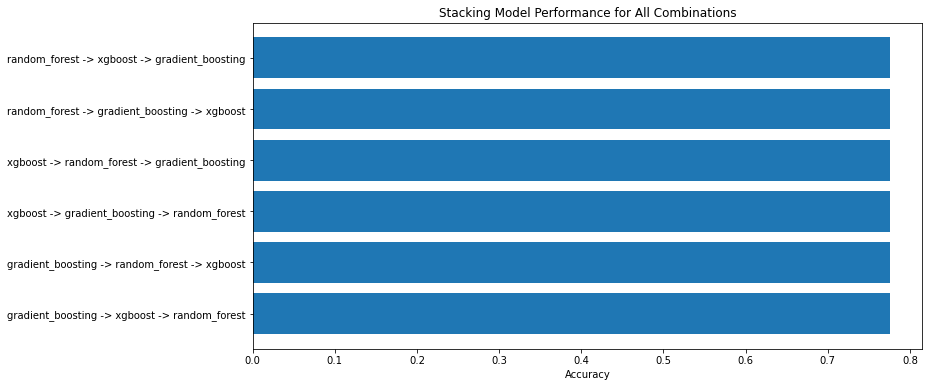

In [5]:
base_models = [
    ('gradient_boosting', gradient_boosting),
    ('xgboost', xgboost),
    ('random_forest', random_forest),
]

meta_model = chi_square_pruned_tree

base_combinations = list(itertools.permutations(base_models, len(base_models)))
results = []

for base_combination in base_combinations:
    base_train_preds = []
    for name, model in base_combination:
        model.fit(X_train, y_train)
        base_train_preds.append(model.predict(X_train))
    
    stacked_features = np.column_stack(base_train_preds)
    meta_model.fit(stacked_features, y_train)

    base_test_preds = [model.predict(X_test) for _, model in base_combination]
    stacked_test_features = np.column_stack(base_test_preds)
    y_pred = meta_model.predict(stacked_test_features)

    accuracy = accuracy_score(y_test, y_pred)

    results.append({
        'Base Models': [name for name, _ in base_combination],
        'Accuracy': accuracy
    })

results_df = pd.DataFrame(results)
best_result = results_df.loc[results_df['Accuracy'].idxmax()]

print("All Results:")
print(results_df)
print("\nBest Result:")
print(best_result)

plt.figure(figsize=(12, 6))
plt.barh(
    results_df.index,
    results_df['Accuracy'],
    tick_label=[" -> ".join(row['Base Models']) for _, row in results_df.iterrows()]
)
plt.xlabel("Accuracy")
plt.title("Stacking Model Performance for All Combinations")
plt.show()
